# Option Pricing Models

Currently, the focus will be on European Options. 

1. BSM - Analytical
2. Binomial 

- Deribit uses the black scholes model to obtain IV. Is that wrong?
- Assuming market is correct,
  - How can we make the spread for the options smaller?
  - Is that just the lack of a taker within the orderbook?
  - How likely is adverse selection going to occur?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 1 Analytical

## 11 Binomial Tree
For a multi-step binomial tree with n steps, the risk-neutral pricing formula becomes:

$$f = e^{-rT} \sum_{i=0}^{n} \binom{n}{i} p^i (1-p)^{n-i} f_{i}$$

Where:
- $f$ = option value today
- $f_{i}$ = option payoff at expiration for path with i up moves and (n-i) down moves
- $p$ = risk-neutral probability of an up move at each step, given by $p = \frac{e^{r\Delta t} - d}{u - d}$
- $\Delta t$ = time step size, where $\Delta t = \frac{T}{n}$
- $\binom{n}{i}$ = binomial coefficient representing the number of different paths with i up moves
- $r$ = risk-free rate
- $T$ = total time to expiration
- $u$ = factor by which stock price increases in an up move
- $d$ = factor by which stock price decreases in a down move

In this multi-step formula, $f_i$ represents the option payoff for any particular end-state of the tree after n steps. If the option is a European option, $f_i$ is simply the payoff at expiration.

For a call option: $f_i = \max(S_0 u^i d^{n-i} - K, 0)$
For a put option: $f_i = \max(K - S_0 u^i d^{n-i}, 0)$

Where:
- $S_0$ = initial stock price
- $K$ = strike price

This formula calculates the expected value of all possible option payoffs at expiration under the risk-neutral measure, discounted back to present value.

In [12]:
import numpy as np

def binomial_option_price(S_0, K, sigma, r, T, n, option_type='call'):
    """
    Calculates the price of an option using the binomial tree model.
    
    Parameters:
    -----------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    sigma : float
        Volatility of the underlying asset
    r : float
        Risk-free interest rate (annualized)
    T : float
        Time to expiration (in years)
    n : int
        Number of time steps in the binomial tree
    option_type : str
        Type of option - 'call' or 'put'
        
    Returns:
    --------
    float : Option price
    """
    # Calculate time step
    dt = T / n
    
    # Calculate up and down factors
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    
    # Calculate risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)
    discount_factor = np.exp(-r * dt)
    # Initialize asset prices at maturity (n time steps)
    asset_prices = np.zeros(n + 1)
    for i in range(n + 1):
        asset_prices[i] = S_0 * (u ** (n - i)) * (d ** i)
    
    # Initialize option values at maturity
    option_values = np.zeros(n + 1)
    
    # Calculate option payoffs at maturity
    for i in range(n + 1):
        if option_type.lower() == 'call':
            option_values[i] = max(0, asset_prices[i] - K)
        else:  # put option
            option_values[i] = max(0, K - asset_prices[i])
    
    # Backward induction through the tree
    for step in range(n - 1, -1, -1):
        for i in range(step + 1):
            # Risk-neutral valuation: discounted expected value
            option_values[i] = discount_factor * (p * option_values[i] + (1 - p) * option_values[i + 1])
    
    # Return the option price (value at the root of the tree)
    return option_values[0]

In [16]:
import numpy as np

def binomial_option_price_withdata(S_0, K, annualized_volatility, risk_free_rate, T, steps, option_type='call'):
    """
    Calculate option price using a binomial tree model with NumPy arrays for efficiency.
    
    Parameters:
    -----------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    annualized_volatility : float
        Volatility of the underlying asset (annualized)
    risk_free_rate : float
        Risk-free interest rate (annualized)
    T : float
        Time to expiration (in years)
    steps : int
        Number of time steps in the binomial tree
    option_type : str
        Type of option - 'call' or 'put'
        
    Returns:
    --------
    dict : Contains the option price, stock and option trees, and parameters
    """
    # Calculate parameters
    dt = T / steps
    f_u = np.exp(annualized_volatility * np.sqrt(dt))
    f_d = 1 / f_u
    p = (np.exp(risk_free_rate * dt) - f_d) / (f_u - f_d)
    discount = np.exp(-risk_free_rate * dt)
    
    # Initialize stock and option price trees as NumPy arrays
    # Each row represents a time step, with appropriate width for each step
    stock_tree = np.zeros((steps + 1, steps + 1))
    option_tree = np.zeros((steps + 1, steps + 1))
    
    # Build the stock price tree (forward)
    for i in range(steps + 1):
        for j in range(i + 1):
            # Stock price at node (i, j): i is time step, j is number of up moves
            stock_tree[i, j] = S_0 * (f_u ** j) * (f_d ** (i - j))
            
            # At expiration, calculate option payoffs
            if i == steps:
                if option_type.lower() == 'call':
                    option_tree[i, j] = max(stock_tree[i, j] - K, 0)
                else:  # put option
                    option_tree[i, j] = max(K - stock_tree[i, j], 0)
    
    # Calculate option prices by backward induction
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            # Option price at each node using risk-neutral valuation
            option_tree[i, j] = discount * (p * option_tree[i+1, j+1] + (1-p) * option_tree[i+1, j])
    
    return {
        'steps': steps,
        'stock_tree': stock_tree,
        'option_tree': option_tree,
        'parameters': {
            'f_u': f_u,
            'f_d': f_d,
            'p': p,
            'dt': dt,
            'S_0': S_0,
            'discount': discount
        },
        'option_price': option_tree[0, 0]
    }

In [15]:
# Example parameters
S_0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity (in years)
r = 0.05    # Risk-free rate
sigma = 0.2 # Volatility
n = 12

binomial_option_price(
    S_0=S_0,
    K=K,
    sigma=sigma,
    r=r,
    T=T,
    n=n,
    option_type='call'
)

10.285849516002099

In [17]:
binomial_option_price_withdata(
    S_0=S_0,
    K=K,
    annualized_volatility=sigma,
    risk_free_rate=r,
    T=T,
    steps=n,
    option_type='call'
)

{'steps': 12,
 'stock_tree': array([[100.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [ 94.39000224, 105.9434237 ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [ 89.09472523, 100.        , 112.24009024,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [ 84.09651314,  94.39000224, 105.9434237 , 118.91099436,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [ 79.37870064,  89.09472523, 100.        , 112.24009024,
         125.97837858,   0.    

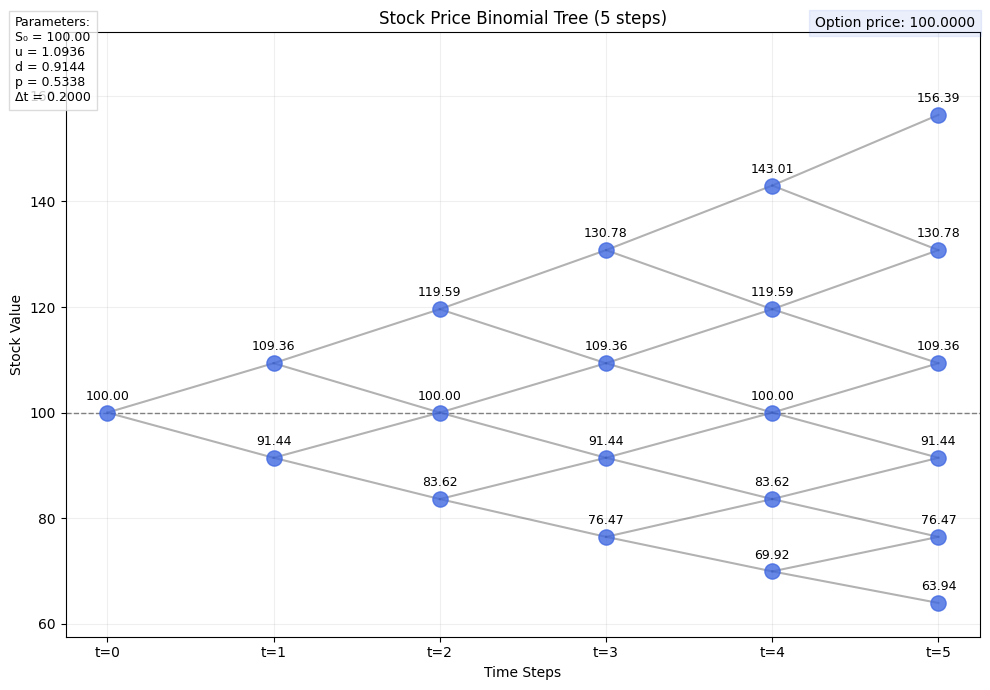

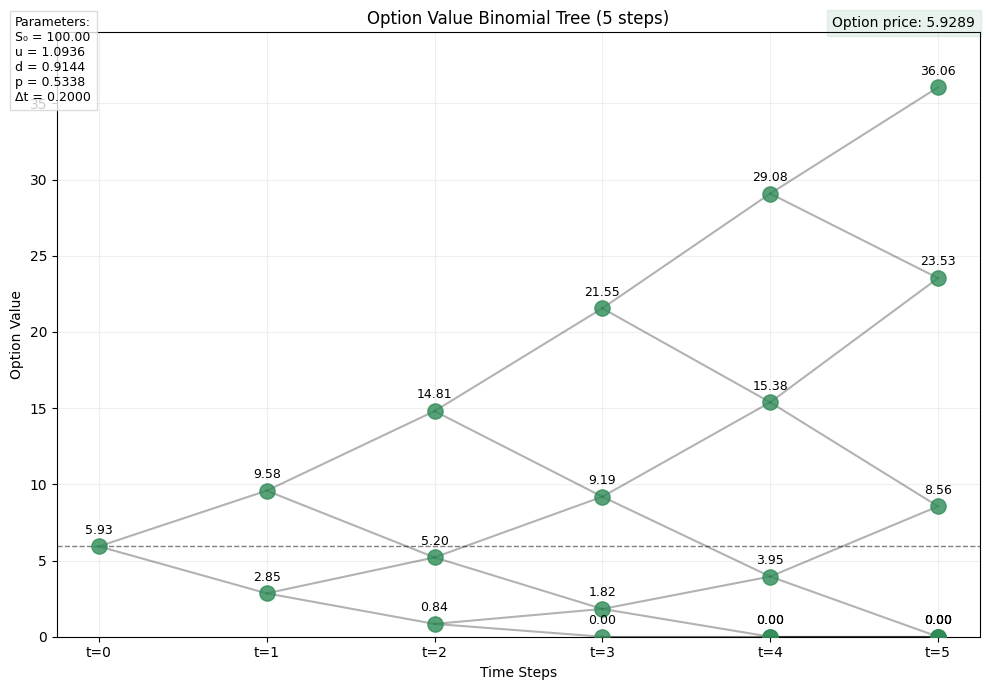

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_binomial_tree_numpy(tree_info, tree_type='stock'):
    """
    Visualize a binomial tree using actual values for the y-axis.
    Compatible with NumPy-based binomial tree results.
    
    Parameters:
    tree_info (dict): Dictionary containing the tree structure and parameters
    tree_type (str): 'stock' or 'option' to specify which tree to visualize
    """
    steps = tree_info['steps']
    
    if tree_type == 'stock':
        tree = tree_info['stock_tree']
        title = 'Stock Price Binomial Tree'
        node_color = 'royalblue'
    else:
        tree = tree_info['option_tree']
        title = 'Option Value Binomial Tree'
        node_color = 'seagreen'
    
    # Create figure with appropriate size
    fig_width = max(10, steps * 1.5)
    fig_height = max(7, steps * 1.2)
    plt.figure(figsize=(fig_width, fig_height))
    
    # Find valid values in the NumPy arrays (non-zero values represent actual nodes)
    all_values = []
    tree_list = []  # Convert NumPy arrays to lists of valid values for each level
    
    for i in range(steps + 1):
        level_values = [tree[i, j] for j in range(i + 1)]
        tree_list.append(level_values)
        all_values.extend(level_values)
    
    # Find min/max values for y-axis scaling
    min_val = min(all_values) * 0.9  # Add 10% padding
    max_val = max(all_values) * 1.1
    
    # Plot nodes and connections
    for i in range(steps + 1):
        # Calculate x-positions (evenly spaced time steps)
        x_positions = [i] * len(tree_list[i])
        
        # Use actual values for y-positions
        y_positions = tree_list[i]
        
        # Plot nodes
        plt.scatter(x_positions, y_positions, s=120, color=node_color, alpha=0.8, zorder=10)
        
        # Add value labels
        for j, value in enumerate(y_positions):
            if abs(value) < 1000:
                value_str = f'{value:.2f}'
            else:
                value_str = f'{value:.0f}'
                
            plt.annotate(value_str, (x_positions[j], y_positions[j]),
                        xytext=(0, 7), textcoords='offset points',
                        ha='center', va='bottom', fontsize=9, zorder=15)
        
        # Draw connections to child nodes
        if i < steps:
            for j, y_pos in enumerate(y_positions):
                # Draw up connection
                if j < len(tree_list[i+1]) - 1:
                    plt.plot([i, i+1], [y_pos, tree_list[i+1][j+1]], 
                             'k-', alpha=0.3, zorder=5)
                    
                    # Add up factor label for first step
                    if i == 0 and steps <= 3:
                        midpoint_x = (i + i+1) / 2
                        midpoint_y = (y_pos + tree_list[i+1][j+1]) / 2
                        plt.text(midpoint_x, midpoint_y, f"×{tree_info['parameters']['f_u']:.2f}",
                                fontsize=8, ha='center', va='bottom',
                                bbox=dict(facecolor='white', alpha=0.7, edgecolor=None))
                
                # Draw down connection
                if j < len(tree_list[i+1]):
                    plt.plot([i, i+1], [y_pos, tree_list[i+1][j]], 
                             'k-', alpha=0.3, zorder=5)
                    
                    # Add down factor label for first step
                    if i == 0 and steps <= 3:
                        midpoint_x = (i + i+1) / 2
                        midpoint_y = (y_pos + tree_list[i+1][j]) / 2
                        plt.text(midpoint_x, midpoint_y, f"×{tree_info['parameters']['f_d']:.2f}",
                                fontsize=8, ha='center', va='top',
                                bbox=dict(facecolor='white', alpha=0.7, edgecolor=None))
    
    # Set x-axis ticks and labels
    plt.xticks(range(steps + 1), [f't={i}' for i in range(steps + 1)])
    
    # Add information text box
    info_text = (
        f"Parameters:\n"
        f"S₀ = {tree_info['parameters']['S_0']:.2f}\n"
        f"u = {tree_info['parameters']['f_u']:.4f}\n"
        f"d = {tree_info['parameters']['f_d']:.4f}\n"
        f"p = {tree_info['parameters']['p']:.4f}\n"
        f"Δt = {tree_info['parameters']['dt']:.4f}"
    )
    
    plt.figtext(0.02, 0.97, info_text, fontsize=9, va='top',
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray'))
    
    # Add option price for option tree
    if tree_type == 'option' and 'option_price' in tree_info:
        option_price = tree_info['option_price']
    else:
        option_price = tree[0, 0]
    
    plt.axhline(option_price, color='gray', linestyle='--', linewidth=1)
    plt.figtext(
        0.98, 0.97, 
        f"Option price: {option_price:.4f}", 
        fontsize=10, ha='right', va='top',
        bbox=dict(facecolor='seagreen' if tree_type=='option' else 'royalblue', 
                 alpha=0.1, edgecolor='seagreen' if tree_type=='option' else 'royalblue')
    )
    
    plt.title(f"{title} ({steps} {'step' if steps == 1 else 'steps'})")
    plt.xlabel('Time Steps')
    plt.ylabel(f"{'Stock' if tree_type=='stock' else 'Option'} Value")
    plt.grid(True, alpha=0.2)
    plt.ylim(min_val, max_val)
    plt.tight_layout()
    
    plt.show()

# Generate tree data
result = binomial_option_price_withdata(100, 100, 0.2, 0.05, 1, 5, 'put')

# Visualize stock tree
visualize_binomial_tree_numpy(result, 'stock')
visualize_binomial_tree_numpy(result, 'option')

# # Visualize option tree
# plt_option = visualize_binomial_tree_numpy(result, 'option')
# plt_option.show()

## 12 BSM

### Partial Differential Equation
The Black-Scholes-Merton (BSM) model is a mathematical framework used to price options and other derivative securities. At its core is a partial differential equation (PDE) that describes how the price of a derivative evolves over time.
The BSM PDE for the price $V(S,t)$ of an option is:
$$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} = rV$$
Where:

- $S$ = underlying asset price
- $t$ = time
- $\sigma$ = volatility of the underlying asset
- $r$ = risk-free interest rate
- $V(S,t)$ = option price as a function of asset price and time

#### Assumptions

1. The price of the underlying asset follows a geometric Brownian motion with constant drift and volatility
2. No arbitrage opportunities exist
3. It's possible to build a risk-free portfolio by combining the option and the underlying asset
4. Frictionless markets (no transaction costs or taxes)
5. Continuous trading is possible
6. The risk-free rate is constant and the same for all maturities
7. The underlying asset pays no dividends

The derivation uses Itô's lemma and the construction of a delta-hedged portfolio that must earn the risk-free rate in the absence of arbitrage.

### European Option Solution

#### European Call Option
The analytical solution for a European call option is:

$$C(S,t) = SN(d_1) - Ke^{-r(T-t)}N(d_2)$$

#### European Put Option
The analytical solution for a European put option is:

$$P(S,t) = Ke^{-r(T-t)}N(-d_2) - SN(-d_1)$$

Where:

$$d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}$$

$$d_2 = d_1 - \sigma\sqrt{T-t}$$


- $T$ is the expiration time (maturity date) (in years)
- $t$ is the current time (in years)

And $N(x)$ is the cumulative distribution function of the standard normal distribution:

$$N(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-\frac{z^2}{2}}dz$$

#### Put-Call Parity
The relationship between European put and call options with the same strike price and expiration is:

$$C + Ke^{-r(T-t)} = P + S$$

This formula allows us to derive the price of a put option from a call option with the same parameters (or vice versa).

#### Interpretation of the Formula
The Black-Scholes formula for a European call option can be interpreted as:

$S \cdot N(d_1)$ represents the expected benefit of receiving the stock when the option is exercised
$K e^{-r(T-t)} \cdot N(d_2)$ represents the present value of paying the strike price on the expiration date

$N(d_2)$ can be interpreted as the risk-neutral probability that the option will be exercised, while $N(d_1)$ is the delta of the option, representing the sensitivity of the option price to changes in the underlying asset price.
### Key Greeks
The "Greeks" measure the sensitivity of the option price to various parameters:
#### Delta (Δ)
- **Call**: $\Delta_{\text{call}} = \frac{\partial C}{\partial S} = N(d_1)$
- **Put**: $\Delta_{\text{put}} = \frac{\partial P}{\partial S} = N(d_1) - 1 = -N(-d_1)$
- *Interpretation*: Sensitivity to changes in the underlying price

#### Gamma (Γ)
- **Call**: $\Gamma_{\text{call}} = \frac{\partial^2 C}{\partial S^2} = \frac{N'(d_1)}{S\sigma\sqrt{T-t}}$
- **Put**: $\Gamma_{\text{put}} = \frac{\partial^2 P}{\partial S^2} = \frac{N'(d_1)}{S\sigma\sqrt{T-t}}$
- *Interpretation*: Rate of change of Delta (same for calls and puts)

#### Theta (Θ)
- **Call**: $\Theta_{\text{call}} = \frac{\partial C}{\partial t} = -\frac{S\sigma N'(d_1)}{2\sqrt{T-t}} - rKe^{-r(T-t)}N(d_2)$
- **Put**: $\Theta_{\text{put}} = \frac{\partial P}{\partial t} = -\frac{S\sigma N'(d_1)}{2\sqrt{T-t}} + rKe^{-r(T-t)}N(-d_2)$
- *Interpretation*: Sensitivity to the passage of time

#### Vega (ν)
- **Call**: $\text{Vega}_{\text{call}} = \frac{\partial C}{\partial \sigma} = S\sqrt{T-t}N'(d_1)$
- **Put**: $\text{Vega}_{\text{put}} = \frac{\partial P}{\partial \sigma} = S\sqrt{T-t}N'(d_1)$
- *Interpretation*: Sensitivity to volatility (same for calls and puts)

#### Rho (ρ)
- **Call**: $\rho_{\text{call}} = \frac{\partial C}{\partial r} = K(T-t)e^{-r(T-t)}N(d_2)$
- **Put**: $\rho_{\text{put}} = \frac{\partial P}{\partial r} = -K(T-t)e^{-r(T-t)}N(-d_2)$
- *Interpretation*: Sensitivity to interest rates

Where:
- $N(x)$ is the standard normal cumulative distribution function
- $N'(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$ is the standard normal probability density function
- $d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}$
- $d_2 = d_1 - \sigma\sqrt{T-t}$

### Limitations and Extensions
The standard BSM model has several limitations:

- Assumption of constant volatility (which doesn't match market reality)
- No consideration for dividends
- Assumes European-style options (cannot be exercised early)
- Assumes log-normal distribution of returns

Extensions to the model include:

- Merton's extension for dividend-paying stocks
- Models for American options
- Stochastic volatility models (e.g., Heston model)
- Jump-diffusion models
- Local volatility models (e.g., Dupire's model)

In [23]:
import numpy as np
from scipy.stats import norm

def calculate_d1_d2(S, K, r, q, sigma, T):
    """
    Calculate the d1 and d2 parameters for the Black-Scholes-Merton model.
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    q : float
        Dividend yield (annualized)
    sigma : float
        Volatility of the underlying asset (annualized)
    T : float
        Time to expiration (in years)
        
    Returns:
    --------
    tuple : (d1, d2) parameters
    """
    # Handle the case of very small time to expiration
    if T < 1e-10:
        return 0, 0
    
    # Calculate d1
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    # Calculate d2
    d2 = d1 - sigma * np.sqrt(T)
    
    return d1, d2

def black_scholes_merton(S, K, r, sigma, T, option_type='call', q=0):
    """
    Calculate option price using the Black-Scholes-Merton model with dividends.
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility of the underlying asset (annualized)
    T : float
        Time to expiration (in years)
    option_type : str
        Type of option - 'call' or 'put'
    q : float
        Dividend yield (annualized), defaults to 0 for no dividends
        
    Returns:
    --------
    dict : Contains the option price and Greeks
    """
    # Calculate d1 and d2
    d1, d2 = calculate_d1_d2(S, K, r, q, sigma, T)
    
    # Handle the case where time to expiration is extremely small
    if T < 1e-10:
        if option_type.lower() == 'call':
            price = max(0, S - K)
        else:  # put
            price = max(0, K - S)
        return {
            'price': price,
            'delta': 0,
            'gamma': 0,
            'theta': 0,
            'vega': 0,
            'rho': 0
        }
    
    # Calculate option price
    if option_type.lower() == 'call':
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        
        # Calculate Greeks
        delta = np.exp(-q * T) * norm.cdf(d1)
        rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100  # Divided by 100 for percentage change
    else:  # put option
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        
        # Calculate Greeks
        delta = np.exp(-q * T) * (norm.cdf(d1) - 1)
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100  # Divided by 100 for percentage change
    
    # Common Greeks for both call and put
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T) / 100  # Divided by 100 for percentage change
    
    # Theta calculation (per calendar day, assuming 365 days in a year)
    if option_type.lower() == 'call':
        theta = (-S * np.exp(-q * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) 
                - r * K * np.exp(-r * T) * norm.cdf(d2)
                + q * S * np.exp(-q * T) * norm.cdf(d1)) / 365
    else:  # put option
        theta = (-S * np.exp(-q * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                + r * K * np.exp(-r * T) * norm.cdf(-d2)
                - q * S * np.exp(-q * T) * norm.cdf(-d1)) / 365
    
    return {
        'price': price,
        'delta': delta,
        'gamma': gamma,
        'theta': theta,
        'vega': vega,
        'rho': rho,
        'd1': d1,
        'd2': d2,
        'parameters': {
            'S': S,
            'K': K,
            'r': r,
            'q': q,
            'sigma': sigma,
            'T': T,
            'option_type': option_type
        }
    }

# Example usage:
S0 = 100        # Current stock price
K = 100         # Strike price
r = 0.05        # Risk-free rate (5%)
sigma = 0.2     # Volatility (20%)
T = 1           # Time to expiration (1 year)
q = 0        # Dividend yield (2%)

# Calculate call option price with dividends
call_result = black_scholes_merton(S0, K, r, sigma, T, 'call', q)
print(f"Call option price: ${call_result['price']:.4f}")

# Calculate put option price with no dividends
put_result = black_scholes_merton(S0, K, r, sigma, T, 'put', 0)
print(f"Put option price: ${put_result['price']:.4f}")

Call option price: $10.4506
Put option price: $5.5735


# 2 Numerical Methods

## 21 Monte Carlo

European Call Option Price: $6.3307
95% Confidence Interval: [6.2738, 6.3875]


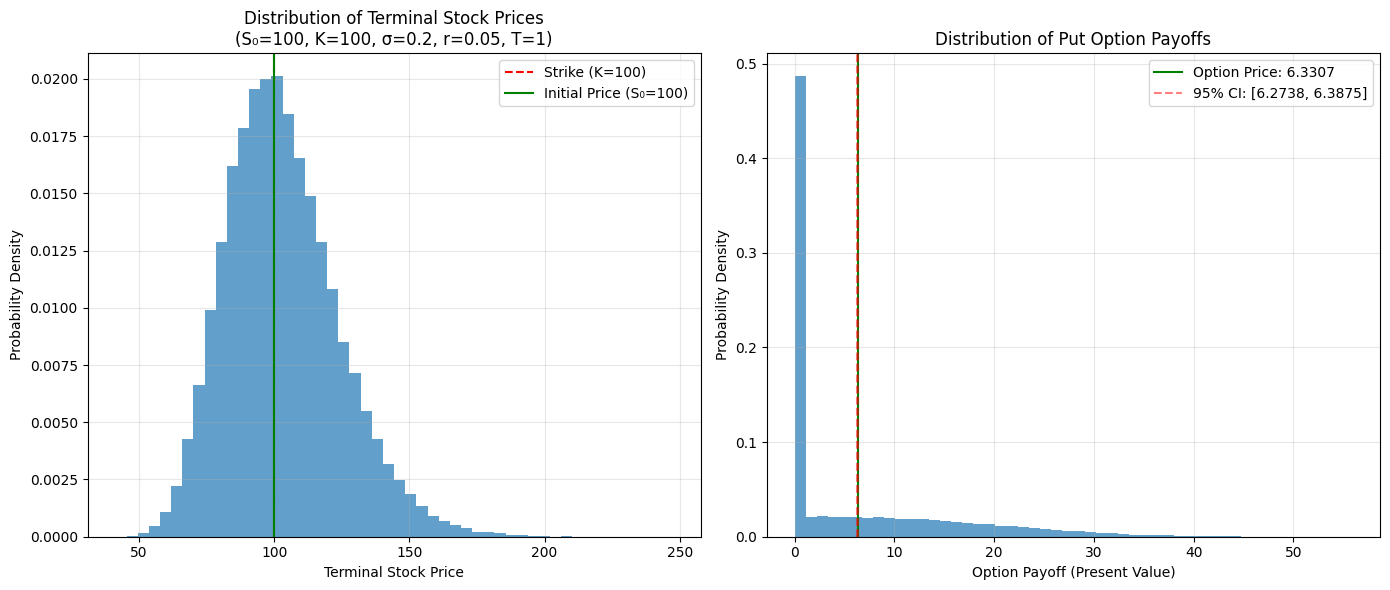

In [27]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def monte_carlo_european_option(S0, K, r, sigma, T, option_type='call', q=0, paths=10000, 
                                antithetic=True, control_variate=False, seed=42):
    """
    Price European options using Monte Carlo simulation.
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility of the underlying asset (annualized)
    T : float
        Time to expiration (in years)
    option_type : str
        Type of option - 'call' or 'put'
    q : float
        Dividend yield (annualized), defaults to 0 for no dividends
    paths : int
        Number of simulation paths
    antithetic : bool
        Whether to use antithetic variates for variance reduction
    control_variate : bool
        Whether to use control variates for variance reduction
    seed : int or None
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Contains option price, confidence interval, and simulation data
    """
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Adjust paths if using antithetic variates
    actual_paths = paths // 2 if antithetic else paths
    
    # Generate random normal samples
    Z = np.random.normal(0, 1, actual_paths)
    
    # Calculate terminal stock prices directly (single step)
    ST = S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # If using antithetic variates, generate complementary terminal prices
    if antithetic:
        ST_antithetic = S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * (-Z))
        ST = np.concatenate((ST, ST_antithetic))
    
    # Calculate payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:  # put
        payoffs = np.maximum(K - ST, 0)
    
    # Discount payoffs to present value
    present_values = np.exp(-r * T) * payoffs
    
    # Calculate option price as the mean of discounted payoffs
    option_price = np.mean(present_values)
    
    # Calculate standard error
    std_error = np.std(present_values) / np.sqrt(len(present_values))
    
    # If using control variates
    if control_variate:
        # Calculate analytical Black-Scholes price
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        if option_type.lower() == 'call':
            bs_price = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            # Calculate control variate
            control_payoffs = np.exp(-r * T) * np.maximum(ST - K, 0)
        else:  # put
            bs_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)
            # Calculate control variate
            control_payoffs = np.exp(-r * T) * np.maximum(K - ST, 0)
        
        # Calculate control variate estimator
        control_mean = np.mean(control_payoffs)
        covariance = np.cov(present_values, control_payoffs)[0, 1]
        variance = np.var(control_payoffs)
        optimal_beta = covariance / variance
        
        # Adjust option price using control variate
        adjusted_present_values = present_values - optimal_beta * (control_payoffs - bs_price)
        option_price = np.mean(adjusted_present_values)
        std_error = np.std(adjusted_present_values) / np.sqrt(len(adjusted_present_values))
    
    return {
        'price': option_price,
        'std_error': std_error,
        'confidence_interval_95': [option_price - 1.96 * std_error, option_price + 1.96 * std_error],
        'paths': len(present_values),
        'parameters': {
            'S0': S0,
            'K': K,
            'r': r,
            'q': q,
            'sigma': sigma,
            'T': T,
            'option_type': option_type
        },
        'terminal_prices': ST
    }

def plot_monte_carlo_european_results(simulation_result, bins=50):
    """
    Plot the terminal stock price distribution and option payoff distribution.
    
    Parameters:
    -----------
    simulation_result : dict
        Result dictionary from monte_carlo_european_option function
    bins : int
        Number of bins for histograms
    """
    # Extract data from simulation results
    ST = simulation_result['terminal_prices']
    price = simulation_result['price']
    ci = simulation_result['confidence_interval_95']
    params = simulation_result['parameters']
    
    # Calculate payoffs
    if params['option_type'].lower() == 'call':
        payoffs = np.maximum(ST - params['K'], 0)
    else:  # put
        payoffs = np.maximum(params['K'] - ST, 0)
    
    # Discount payoffs to present value
    present_values = np.exp(-params['r'] * params['T']) * payoffs
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot histogram of terminal stock prices
    ax1.hist(ST, bins=bins, alpha=0.7, density=True)
    ax1.axvline(x=params['K'], color='r', linestyle='--', label=f"Strike (K={params['K']})")
    ax1.axvline(x=params['S0'], color='g', linestyle='-', label=f"Initial Price (S₀={params['S0']})")
    
    # Add labels and title
    ax1.set_xlabel('Terminal Stock Price')
    ax1.set_ylabel('Probability Density')
    ax1.set_title(f"Distribution of Terminal Stock Prices\n"
                 f"(S₀={params['S0']}, K={params['K']}, σ={params['sigma']}, r={params['r']}, T={params['T']})")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot histogram of discounted payoffs
    ax2.hist(present_values, bins=bins, alpha=0.7, density=True)
    
    # Add vertical line for option price
    ax2.axvline(x=price, color='g', linestyle='-', label=f"Option Price: {price:.4f}")
    
    # Add confidence interval
    ax2.axvline(x=ci[0], color='r', linestyle='--', alpha=0.5, label=f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    ax2.axvline(x=ci[1], color='r', linestyle='--', alpha=0.5)
    
    # Add labels and title
    ax2.set_xlabel('Option Payoff (Present Value)')
    ax2.set_ylabel('Probability Density')
    ax2.set_title(f"Distribution of {params['option_type'].capitalize()} Option Payoffs")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# European call option
result = monte_carlo_european_option(
    S0=100, K=100, r=0.05, sigma=0.2, T=1, 
    option_type='put', q=0.02, paths=100000
)
print(f"European Call Option Price: ${result['price']:.4f}")
print(f"95% Confidence Interval: [{result['confidence_interval_95'][0]:.4f}, {result['confidence_interval_95'][1]:.4f}]")

# Plot the simulation results
plot_monte_carlo_european_results(result)

## 22 Finite Differences

Finite difference methods (also called finite element methods) are used to price options by approximating the (continuous-time) differential equation that describes how an option price evolves over time by a set of (discrete-time) difference equations. The discrete difference equations may then be solved iteratively to calculate a price for the option.

[Goddard Consulting - Finite Difference Methods](http://www.goddardconsulting.ca/option-pricing-finite-diff-index.html)

1. Explicit
2. Implicit
3. Crank-Nicholson

## 23 Fourier / Laplace Transform

# 3 Advanced Stochastic Methods 

## 31 Heston Model

## 32 Bates Model

## 33 Local Volatility - Dupire

# 4 Rough Volatility